In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pynvml

def get_memory_free_MiB(gpu_index):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(gpu_index))
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.free // 1024 ** 2

In [3]:
# uncomment this code to check the available vrams of all gpus on puffer

for i in range(4):
    print(f'GPU {i} available vram {get_memory_free_MiB(i)}')

GPU 0 available vram 10666
GPU 1 available vram 10844
GPU 2 available vram 11000
GPU 3 available vram 588


In [4]:
import torch

print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

PyTorch version: 2.3.1+cu121
CUDA is available. Using GPU.


In [5]:
torch.cuda.set_device(2)

In [6]:
torch.cuda.get_device_name(2)

'NVIDIA GeForce RTX 2080 Ti'

In [7]:
torch.cuda.current_device()

2

In [8]:
tensor = torch.randn(3, 3, device=device)

print(f"Tensor is on: {tensor.device}")

Tensor is on: cuda:2


In [9]:
SEED = 69
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
import torchtext, torchdata

print(f'torchtext version: {torchtext.__version__}')
print(f'torchdata version: {torchdata.__version__}')

torchtext.disable_torchtext_deprecation_warning()

torchtext version: 0.18.0+cpu
torchdata version: 0.8.0+cpu


In [11]:
import datasets
import warnings
warnings.filterwarnings("ignore", message=".*huggingface_hub.*symlinks.*") # disable hugging facewarning
datasets.config.HF_DATASETS_CACHE = "./downloaded_datasets"
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'
dataset_name = 'archx64/english-burmese-parallel'
dataset = datasets.load_dataset(dataset_name)

In [12]:
dataset_config = datasets.get_dataset_config_names(dataset_name)
dataset_config

['default']

In [13]:
dataset = datasets.load_dataset(dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 14074
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 3016
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 3016
    })
})

In [14]:
dataset['train'][256]

{'en': 'While nearly all cover of the 2008 Presidential election has focused on the Democratic and Republican candidates, the race for the White House also includes independents and third party candidates.',
 'my': '၂၀ဝ၈ခုနှစ် သမ္မတရွေးကောက်ပွဲ ၏ အစမှအဆုံး အကုန်လုံး နီးပါး သည် ဒီမိုကရေစီဝါဒကိုလိုလားသော ကိုယ်စားလှယ်များ နှင့် သမ္မတစနစ်ကိုလိုလားသော ကိုယ်စားလှယ်များ ကို အာရုံစိုက် နေစဉ် ၊ အိမ်ဖြူတော် အတွက် ယှဉ်ပြိုင်အနိုင်လုပွဲ တွင် တစ်သီးပုဂ္ဂလများ နှင့် ကြားနေပါတီကိုယ်စားလှယ်များ လည်း ပါဝင်သည် ။'}

In [15]:
dataset['test'][128]

{'en': 'On October 14, 2008, Canadians will be heading to the polls for the federal election.',
 'my': '၂၀ဝ၈ခုနှစ် ၊ အောက်တိုဘာလ ၁၄ရက် တွင် ၊ ဖက်ဒရယ် ရွေးကောက်ပွဲ အတွက် မဲရေတွက်ခြင်းများ ကို ကနေဒါလူမျိုးများ က ဦးဆောင်လိမ့်မည် ။'}

In [16]:
dataset['validation'][64]

{'en': 'The uncertainty underlined the lack of substantive information behind the rumor.',
 'my': 'ကောလဟာလ နောက်ကွယ် တွင် ခိုင်လုံတိကျတဲ့ သတင်းအချက်အလက် လစ်ဟာနေမှု ကို မသေချာမှု က ထင်ရှားပေါ်လွင်စေခဲ့သည် ။'}

In [17]:
print(f'train size:     {len(dataset['train'])}')
print(f'test size:      {len(dataset['test'])}')
print(f'vaidation size: {len(dataset['validation'])}')

train size:     14074
test size:      3016
vaidation size: 3016


In [18]:
train = [(row['en'], row['my']) for row in dataset['train']]
val = [(row['en'], row['my']) for row in dataset['validation']]
test = [(row['en'], row['my']) for row in dataset['test']]
len(train), len(val), len(test)

(14074, 3016, 3016)

## preprocessing

In [19]:
# !python -m spacy download en_core_web_sm

In [20]:
# initialize place holders
token_transform = {}
vocab_transform = {}

In [21]:
from icu import BreakIterator, Locale

def burmese_tokenizer(sentence):
    bi = BreakIterator.createWordInstance(Locale(TRG_LANGUAGE))
    bi.setText(sentence)
    tokens = []
    start = bi.first()
    for end in bi:
        token = sentence[start:end].strip()  # remove leading/trailing spaces
        if token:  # only add non-empty tokens
            tokens.append(token)
        start = end
    return tokens

In [22]:
from torchtext.data.utils import get_tokenizer


token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")
token_transform[TRG_LANGUAGE] = burmese_tokenizer
token_transform

{'en': functools.partial(<function _spacy_tokenize at 0x7c56e791c540>, spacy=<spacy.lang.en.English object at 0x7c56e0122db0>),
 'my': <function __main__.burmese_tokenizer(sentence)>}

In [23]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

In [24]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

In [25]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #The minimum frequency needed to include a token in the vocabulary. if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [26]:
sample = ['Hello World', 'မင်္ဂလာပါ လောကကြီး']

print('Sentence: ', sample[1])
print('Tokenization: ', token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  မင်္ဂလာပါ လောကကြီး
Tokenization:  ['မင်္ဂလာ', 'ပါ', 'လောက', 'ကြီး']


In [27]:
vocab_transform

{'en': Vocab(), 'my': Vocab()}

In [28]:
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1043, 18, 12, 0, 12]

In [29]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'mark'

In [30]:
# let's try unkown word
mapping[0]

'<unk>'

In [31]:
# special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [32]:
len(mapping)

14761

## Preparing Dataloader

In [33]:
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [34]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [35]:
# test the train loader

for en, _, my in train_loader:
    print(f"English shape: {en.shape}")
    print(f"Burmese shape: {my.shape}")
    break

English shape: torch.Size([16, 46])
Burmese shape: torch.Size([16, 69])


## Design the Model

### Encoder and Encoder Layer

In [36]:
from torch import nn

class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AdditiveAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

In [38]:
class AdditiveAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout, device):
        super().__init__()
        assert hidden_dim % num_heads == 0
        self.hidden_dim  = hidden_dim
        self.num_heads  = num_heads
        self.head_dim = hidden_dim // num_heads

        self.query_fc = nn.Linear(hidden_dim, hidden_dim)
        self.key_fc = nn.Linear(hidden_dim, hidden_dim)
        self.value_fc = nn.Linear(hidden_dim, hidden_dim)

        # additional linear layers for additive attention mechanism
        self.query_transform = nn.Linear(self.head_dim, self.head_dim)
        self.key_transform = nn.Linear(self.head_dim, self.head_dim)
        self.attention_score = nn.Linear(self.head_dim, 1)

        self.output_fc = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        # query = [batch size, query len, hidden dim]
        # key = [batch size, key len, hidden dim]
        # value = [batch size, value len, hidden dim]

        batch_size = query.shape[0]

        # apply linear transformations to query, key, and value
        Q = self.query_fc(query)
        K = self.key_fc(key)
        V = self.value_fc(value)
        # Q = K = V: [batch_size, src len, hidden_dim]

        # reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, num_heads, query len, head_dim]

        # Additive Attention
        query_len = query.shape[1]
        transformed_query = self.query_transform(Q).view(batch_size, self.num_heads, query_len, 1, self.head_dim)

        key_len = key.shape[1]
        transformed_key = self.key_transform(K).view(batch_size, self.num_heads, 1, key_len, self.head_dim)


        # energy = [batch_size, num_heads, query len, key len]
        energy = torch.tanh(transformed_query + transformed_key)
        energy = self.attention_score(energy).squeeze(-1)

        # apply mask to ignore padding tokens
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # attention_weights = [batch_size, num_heads, query len, key len]
        attention_weights = torch.softmax(energy, dim=-1)

        # apply attention weights to the value
        # weighted_values = [batch_size, num_heads, query len, head_dim]
        weighted_values = torch.matmul(self.dropout(attention_weights), V)

        # reshape and concatenate heads
        weighted_values = weighted_values.permute(0, 2, 1, 3).contiguous()
        # weighted_values = [batch_size, query len, num_heads, head_dim]

        weighted_values = weighted_values.view(batch_size, -1, self.hidden_dim)
        # weighted_values = [batch_size, query len, hidden_dim]

        # apply final linear transformation
        output = self.output_fc(weighted_values)
        # output = [batch_size, query len, hidden_dim]

        return output, attention_weights



In [39]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AdditiveAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = AdditiveAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

In [41]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

In [42]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## Training

In [43]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [44]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(14761, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AdditiveAttentionLayer(
          (query_fc): Linear(in_features=256, out_features=256, bias=True)
          (key_fc): Linear(in_features=256, out_features=256, bias=True)
          (value_fc): Linear(in_features=256, out_features=256, bias=True)
          (query_transform): Linear(in_features=32, out_features=32, bias=True)
          (key_transform): Linear(in_features=32, out_features=32, bias=True)
          (attention_score): Linear(in_features=32, out_features=1, bias=True)
          (output_fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

In [45]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

3778816
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
1736704
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
1310

In [46]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [47]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [48]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    elapsed_millis = int((elapsed_time - int(elapsed_time)) * 1000)  # get milliseconds
    return elapsed_mins, elapsed_secs, elapsed_millis

In [50]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [51]:
import time, math

best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}-additive.pt'

train_losses = []
valid_losses = []
total_training_time = 0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()
    epoch_mins, epoch_secs, epoch_millis = epoch_time(start_time, end_time)
    total_training_time += (end_time - start_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s {epoch_millis}ms')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

total_mins, total_secs, total_millis = epoch_time(0, total_training_time)
print(f"Total training time: {total_mins}m {total_secs}s {total_millis}ms")

Epoch: 01 | Time: 0m 48s 280ms
	Train Loss: 5.000 | Train PPL: 148.466
	 Val. Loss: 4.342 |  Val. PPL:  76.897
Epoch: 02 | Time: 0m 47s 97ms
	Train Loss: 4.159 | Train PPL:  64.019
	 Val. Loss: 4.076 |  Val. PPL:  58.911
Epoch: 03 | Time: 0m 47s 944ms
	Train Loss: 3.835 | Train PPL:  46.304
	 Val. Loss: 3.955 |  Val. PPL:  52.192
Epoch: 04 | Time: 0m 47s 855ms
	Train Loss: 3.593 | Train PPL:  36.355
	 Val. Loss: 3.896 |  Val. PPL:  49.225
Epoch: 05 | Time: 0m 43s 305ms
	Train Loss: 3.395 | Train PPL:  29.819
	 Val. Loss: 3.872 |  Val. PPL:  48.032
Total training time: 3m 54s 483ms


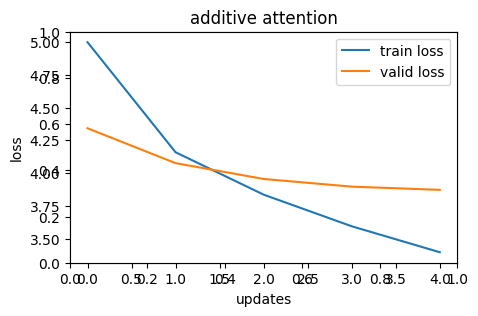

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
plt.title('additive attention')
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
plt.savefig('figures/additive-attention-loss')

In [53]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.895 | Test PPL:  49.134 |


In [54]:
import pickle

transforms = {
    'token_transform': token_transform,
    'vocab_transform': vocab_transform
}

pickle.dump(transforms, open('models/transforms-additive.pkl','wb'))

## Test on random sentences

In [55]:
test[69][0], test[69][1]

('The evening began with an introduction by 12-year-old co-hostess Ioana Ivan followed by an elaborate dance routine.',
 'ညနေခင်း ကို ၁၂ နှစ် အရွယ် ပူးတွဲ ဖျော်ဖြေသူ အိုင်အိုနာ အိုင်ဗန် ကို မိတ်ဆက်ခြင်း နောက်တွင် ခက်ခဲ သိမ်မွေ့ သော အက အစီအစဉ် တစ်ခု နှင့်အတူ စတင် ခဲ့ သည် ။')

In [56]:
src_text = text_transform[SRC_LANGUAGE](test[69][0]).to(device)
src_text

tensor([    2,    14,  1805,   428,    22,    35,  5804,    21,   623,    16,
           55,    16,   168,  1034,    16,     0,     0, 11457,   801,    21,
           35,  9641,     0,  3603,     6,     3], device='cuda:2')

In [57]:
trg_text = text_transform[TRG_LANGUAGE](test[69][1]).to(device)
trg_text

tensor([   2, 4519,    6,  940,   34,  585, 1860, 1110,   18,  183,  161,  175,
         183,  827,    6, 1120,  193,   25, 2622,  881, 6386,   13, 3749,  354,
          16,   19,   17,    9,  128,  180,    5,    4,    8,    3],
       device='cuda:2')

In [58]:
src_text = src_text.reshape(1, -1)

In [59]:
trg_text = trg_text.reshape(1, -1)

In [60]:
src_text.shape, trg_text.shape

(torch.Size([1, 26]), torch.Size([1, 34]))

In [61]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [62]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) 

In [63]:
output.shape

torch.Size([1, 34, 6784])

In [64]:
output = output.squeeze(0)

In [65]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([33, 6784])

In [66]:
output_max = output.argmax(1) #returns max indices

In [67]:
output_max

tensor([1110,   61,  269,   14,  300,  557,   45,   16,  164,  164,  277,  164,
          11,   11,  193,    5,    6,   16,    4,   25,    0,   16,   16,   19,
           6,    9,  128,   16,    5,    4,    8,    3,   37], device='cuda:2')

In [68]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [69]:
for token in output_max:
    print(mapping[token.item()])

ဖျော်ဖြေ
လ
နာရီ
တွင်
အမျိုးသား
ဖွ
ရေး
တစ်
ပီ
ပီ
ဆာ
ပီ
က
က
ဆက်
ခဲ့
ကို
တစ်
သည်
ခြင်း
<unk>
တစ်
တစ်
ခု
ကို
င့်
အတူ
တစ်
ခဲ့
သည်
။
<eos>
ပါ


## Attention

In [70]:
attentions.shape

torch.Size([1, 8, 34, 26])

In [71]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([34, 26])

In [72]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>', 'Hello', 'World', '<eos>']

In [73]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'ဖျော်ဖြေ',
 'လ',
 'နာရီ',
 'တွင်',
 'အမျိုးသား',
 'ဖွ',
 'ရေး',
 'တစ်',
 'ပီ',
 'ပီ',
 'ဆာ',
 'ပီ',
 'က',
 'က',
 'ဆက်',
 'ခဲ့',
 'ကို',
 'တစ်',
 'သည်',
 'ခြင်း',
 '<unk>',
 'တစ်',
 'တစ်',
 'ခု',
 'ကို',
 'င့်',
 'အတူ',
 'တစ်',
 'ခဲ့',
 'သည်',
 '။',
 '<eos>',
 'ပါ']

In [74]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig('figures/additive-attention')
    plt.show()
    plt.close()

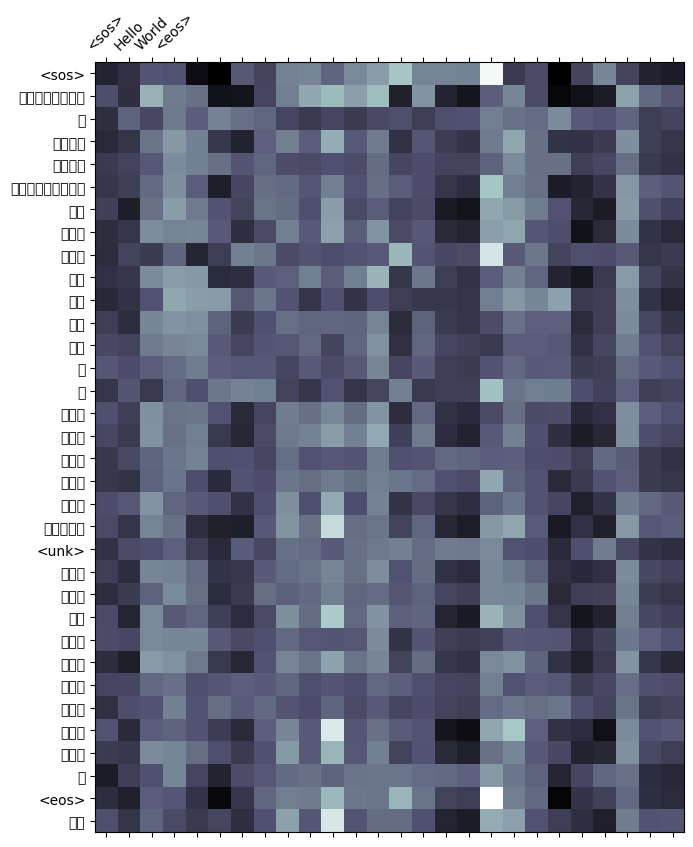

In [75]:
display_attention(src_tokens, trg_tokens, attention)